## CAP5610 HW6 - Yuan Du
Code stored at my Github: https://github.com/YuanEldaif/CAP5610

# Learning with Matrix Data for Recommender Systems

**Building a small recommender system with the matrix data: “ratings.csv”.**<br>
The dataset **[movies-dataset](https://www.kaggle.com/rounakbanik/the-movies-dataset/home)** was used.


In [40]:
# To store the data
import pandas as pd

# To do linear algebra
import numpy as np

# To create plots
import matplotlib.pyplot as plt

# To shift lists
from collections import deque

# To compute similarities between vectors
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import TfidfVectorizer

# To create interactive plots
from plotly.offline import init_notebook_mode, plot, iplot
import plotly.graph_objs as go
init_notebook_mode(connected=True)

# To use recommender systems
import surprise as sp
from surprise.model_selection import cross_validate
from surprise.model_selection import train_test_split

# To create sparse matrices
from scipy.sparse import coo_matrix

# To stack sparse matrices
from scipy.sparse import vstack

## a. Read data

In [2]:
# Load single data-file
df_raw = pd.read_csv('C:/Work/Project/CAP5610/HW/HW6/ratings.csv')
print('Data dimension:',df_raw.shape)

Data dimension: (26024289, 4)


### Filter Sparse Movies And Users
To reduce the dimensionality of the dataset I am filtering rarely rated movies and rarely rating users out.

In [42]:
# Filter sparse movies
min_movie_ratings = 10000
filter_movies = (df_raw['movieId'].value_counts()>min_movie_ratings)
filter_movies = filter_movies[filter_movies].index.tolist()

# Filter sparse users
min_user_ratings = 200
filter_users = (df_raw['userId'].value_counts()>min_user_ratings)
filter_users = filter_users[filter_users].index.tolist()

# Actual filtering
df_filterd = df_raw[(df_raw['movieId'].isin(filter_movies)) & (df_raw['userId'].isin(filter_users))]
del filter_movies, filter_users, min_movie_ratings, min_user_ratings
#print('Shape User-Ratings unfiltered:\t{}'.format(df_raw.shape))
#print('Shape User-Ratings filtered:\t{}'.format(df_filterd.shape))

In [43]:
# Shuffle DataFrame
df_filterd = df_filterd.drop('timestamp', axis=1).sample(frac=1).reset_index(drop=True)

# Testingsize
n = 100000

# Split train- & testset
df_train = df_filterd[:-n]
df_test = df_filterd[-n:]


***
## b & c
Compute the average MAE and RMSE of the Probabilistic Matrix Factorization (PMF), User based Collaborative Filtering, Item based Collaborative Filtering, under the 5-folds cross-validation

In [5]:
# Load dataset into surprise specific data-structure
data = sp.Dataset.load_from_df(df_filterd[['userId', 'movieId', 'rating']].sample(20000), sp.Reader())
#default setting: distance MSD, k=10
benchmark = []
# Iterate over all algorithms
for algorithm in [sp.SVD(biased=False), sp.KNNBasic(sim_options = {'user_based': True }), sp.KNNBasic(sim_options = {'user_based': False}) 
                 ]:
    # Perform cross validation
    results = cross_validate(algorithm, data, measures=['RMSE', 'MAE'], cv=5, verbose=True)
    
    # Get results & append algorithm name
    tmp = pd.DataFrame.from_dict(results).mean(axis=0)
    tmp = tmp.append(pd.Series([str(algorithm).split(' ')[0].split('.')[-1]], index=['Algorithm']))
    
    # Store data
    benchmark.append(tmp)



Evaluating RMSE, MAE of algorithm SVD on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    1.9569  1.9611  1.9578  1.9668  1.9765  1.9638  0.0072  
MAE (testset)     1.5623  1.5659  1.5592  1.5615  1.5808  1.5659  0.0077  
Fit time          0.88    0.84    0.86    0.87    0.88    0.87    0.02    
Test time         0.02    0.02    0.03    0.02    0.02    0.02    0.00    
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Evaluating RMSE, MAE of algorithm KNNBasic on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    1.0042  1.0162  0.9985  0.9995  0.9959  1.0029  0.0072

In [6]:
benchmark=pd.DataFrame(benchmark)

In [7]:
#udpate algrithm name 
newAlgo = ['PMF','UserCF','ItemCF']
benchmark['Algorithm']=newAlgo

***
## d.
Compare the average (mean) performances of User-based collaborative filtering, item-based collaborative filtering, PMF with respect to RMSE and MAE. Which ML model is the best in the movie rating data

PMF,UserCF,ItemCF Average 5 fold test RMSE and MAE: Item based Collaborative Filtering has the lowest RMSE and MAE

In [8]:
benchmark

,test_rmse,test_mae,fit_time,test_time,Algorithm
0,1.963830,1.565934,0.865756,0.022132,PMF
1,1.002866,0.794041,3.773451,0.111114,UserCF
2,1.000830,0.792247,0.016803,0.034330,ItemCF


***
## e.
Examine how the cosine, MSD (Mean Squared Difference), and Pearson similarities impact the performances of User based Collaborative Filtering and
Item based Collaborative Filtering. Plot your results. Is the impact of the three metrics on User based Collaborative Filtering consistent with the impact of the
three metrics on Item based Collaborative Filtering

In [ ]:

benchmarke = []
# Iterate over all algorithms
for algorithm in [sp.KNNBasic(sim_options = {'name':'cosine','user_based': True}), sp.KNNBasic(sim_options = {'name':'MSD', 'user_based':True }),
                 sp.KNNBasic(sim_options = {'name':'pearson','user_based': True}),
                 sp.KNNBasic(sim_options = {'name':'cosine', 'user_based':False }),sp.KNNBasic(sim_options = {'name':'MSD', 'user_based':False }),
                 sp.KNNBasic(sim_options = {'name':'pearson','user_based': False}) 
                 ]:
    # Perform cross validation
    results = cross_validate(algorithm, data, measures=['RMSE', 'MAE'], cv=5, verbose=False)
    
    # Get results & append algorithm name
    tmp = pd.DataFrame.from_dict(results).mean(axis=0)
    tmp = tmp.append(pd.Series([str(algorithm).split(' ')[0].split('.')[-1]], index=['Algorithm']))
    
    # Store data
    benchmarke.append(tmp)

benchmarke=pd.DataFrame(benchmarke)


Pearson similarity metrics has the best performance for both user based and item based collabrative filtering. The impact of the three similarity metrics doesn't have the same effect on user and item based collabrative filtering.
For User collabrative filtering, Cosine is better than MSD;
For Item collabrative filtering, MSD is better than Cosine.

In [10]:

#udpate algrithm name 
newAlgoe = ['Cosine-UserCF','MSD-UserCF','Pearson-UserCF','Cosine-ItemCF','MSD-ItemCF','Pearson-ItemCF']
benchmarke['Algorithm']=newAlgoe

# Store results
surprise_results = benchmarke.set_index('Algorithm').sort_values('test_rmse', ascending=False)
surprise_results

,test_rmse,test_mae,fit_time,test_time
Algorithm,,,,
MSD-UserCF,1.003492,0.794953,3.732721,0.097720
Cosine-ItemCF,1.003383,0.793718,0.028736,0.048252
Cosine-UserCF,1.003145,0.794499,6.015030,0.244773
MSD-ItemCF,1.001508,0.792323,0.019904,0.039973
Pearson-ItemCF,0.997573,0.791060,0.037252,0.034114
Pearson-UserCF,0.997379,0.790967,13.601626,0.359577


In [28]:
#Plot
# Get data
data = surprise_results[['test_rmse', 'test_mae']]
grid = data.values

# Create axis labels
x_axis = [label.split('_')[1].upper() for label in data.columns.tolist()]
y_axis = data.index.tolist()

x_label = 'Function'
y_label = 'Algorithm'


# Get annotations and hovertext
hovertexts = []
annotations = []
for i, y_value in enumerate(y_axis):
    row = []
    for j, x_value in enumerate(x_axis):
        annotation = grid[i, j]
        row.append('Error: {:.4f}<br>{}: {}<br>{}: {}<br>Fit Time: {:.3f}s<br>Test Time: {:.3f}s'.format(annotation, y_label, y_value ,x_label, x_value, surprise_results.loc[y_value]['fit_time'], surprise_results.loc[y_value]['test_time']))
        annotations.append(dict(x=x_value, y=y_value, text='{:.4f}'.format(annotation), ax=0, ay=0, font=dict(color='#000000')))
    hovertexts.append(row)

# Create trace
trace = go.Heatmap(x = x_axis,
                   y = y_axis,
                   z = data.values,
                   text = hovertexts,
                   hoverinfo = 'text',
                   colorscale = 'Picnic',
                   colorbar = dict(title = 'Error'))

# Create layout
layout = go.Layout(title = 'Cross-validated Comparison Of Surprise Algorithms',
                   xaxis = dict(title = x_label),
                   yaxis = dict(title = y_label,
                                tickangle = -40),
                   annotations = annotations)

# Create plot
fig = go.Figure(data=[trace], layout=layout)


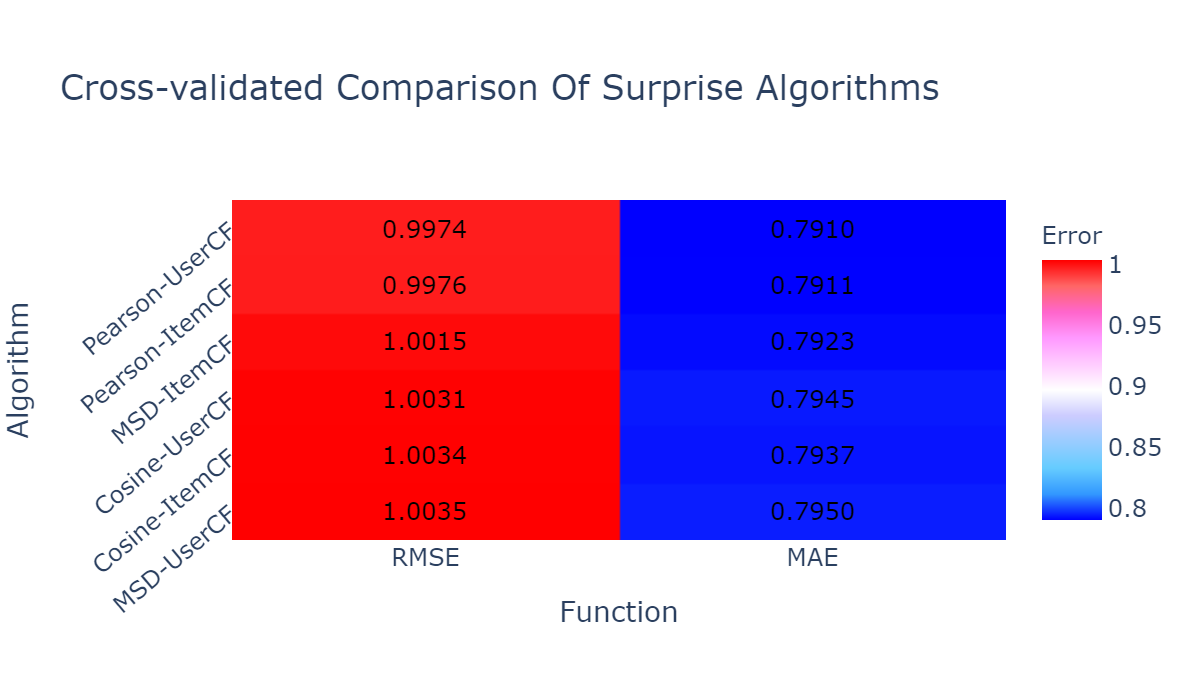

In [29]:
img_bytes = fig.to_image(format="png", width=600, height=350, scale=2)
from IPython.display import Image
Image(img_bytes)

***
## f.
Examine how the number of neighbors impacts the performances of User based Collaborative Filtering and Item based Collaborative Filtering? Plot your results.

In [30]:
# Load dataset into surprise specific data-structure
data = sp.Dataset.load_from_df(df_filterd[['userId', 'movieId', 'rating']].sample(20000), sp.Reader())

In [ ]:
# User based CF optimal k
benchmark_u = []
for i in range(1,30):
    # Perform cross validation
    algorithm =sp.KNNBasic(k=i, sim_options = {'name':'pearson','user_based': True})
    results = cross_validate(algorithm, data, measures=['RMSE'], cv=3, verbose=False)
    
    # Get results & append algorithm name
    tmp = pd.DataFrame.from_dict(results).mean(axis=0)
       
    # Store data
    benchmark_u.append(tmp)

In [ ]:
# Item based CF optimal k
benchmark_i = []
for i in range(1,30):
    # Perform cross validation
    algorithm =sp.KNNBasic(k=i, sim_options = {'name':'pearson','user_based': False})
    results = cross_validate(algorithm, data, measures=['RMSE'], cv=3, verbose=False)
    
    # Get results & append algorithm name
    tmp = pd.DataFrame.from_dict(results).mean(axis=0)
        
    # Store data
    benchmark_i.append(tmp)

In [33]:
benchmark_u = pd.DataFrame(benchmark_u)
benchmark_i = pd.DataFrame(benchmark_i)
acc_user = benchmark_u['test_rmse']
acc_item = benchmark_i['test_rmse']

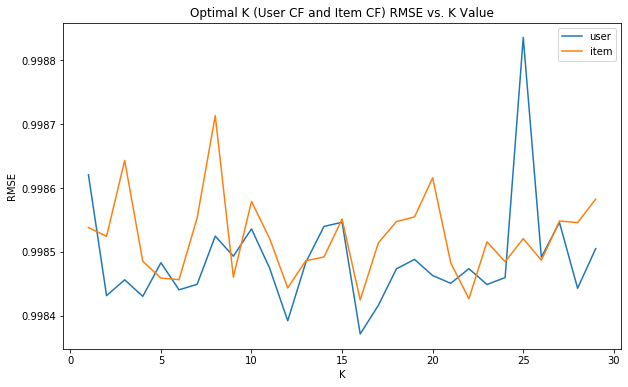

In [34]:
plt.figure(figsize=(10,6))
plt.plot(range(1,30),acc_user,label = "user")
plt.plot(range(1,30),acc_item,label = "item")
plt.title('')
plt.xlabel('K')
plt.ylabel('RMSE')
# Set a title of the current axes.
plt.title('Optimal K (User CF and Item CF) RMSE vs. K Value')
# show a legend on the plot
plt.legend()

***
## g.
Identify the best number of neighbor (denoted by K) for User/Item based collaborative filtering in terms of RMSE. Is the best K of User based collaborative filtering the same with the best K of Item based collaborative filtering?

In [35]:
print("For User CF, the best K is at K = " ,acc_user.idxmin()+1, "with Minimum RMSE:", min(acc_user))
print("For Item CF, the best K is at K = " ,acc_item.idxmin()+1 , "with Minimum RMSE:", min(acc_item))

For User CF, the best K is at K =  16 with Minimum RMSE: 0.9983715772956221
For Item CF, the best K is at K =  16 with Minimum RMSE: 0.998424747645466


The best K (k=16) of User based collaborative filtering is the same with the best K(k=16) of Item based collaborative filtering.